# IMPORTS

In [1]:
import math
import inflection

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from boruta import BorutaPy
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.core.display  import HTML


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error



## Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k - 1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE': rmse}, index=[0])

#def mean_absolute_percentage_error(y, yhat):
#    return np.mean( np.abs( (y - yhat) / y ) )

def cross_validation( x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed( range(1, kfold+1) ):
        if verbose:
            print(f'\nKFold Number:{k}')
            
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*7*6 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*7*6 )

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        xtraining = training.drop( ['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop( ['date', 'sales'], axis=1)
        yvalidation = validation['sales']


        #model
        m = model.fit( xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)


        #perfomance
        m_result = ml_error(model_name, np.expm1( yvalidation ), np.expm1( yhat ))

        #store perfomance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        

    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE CV': np.round(np.mean( mae_list ), 2 ).astype(str) + '+/-' + np.round(np.std( mae_list ), 2 ).astype(str),
                          'MAPE CV': np.round(np.mean( mape_list ), 2 ).astype(str) + '+/-' + np.round(np.std( mape_list ), 2 ).astype(str),
                          'RMSE CV': np.round(np.mean( rmse_list ), 2 ).astype(str) + '+/-' + np.round(np.std( rmse_list ), 2 ).astype(str)}, index=[0])
                    
  

Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [3]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## Data Dimension

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## Data Types 

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

## Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA 

In [10]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
#competition_distance 
    #para os valores NaN, aplica o valor 200.000
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month 
    #para os valores NaN substituir pela coluna da data respectiva
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week   
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval      
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'Jan', 6: 'Jan', 7: 'Jan', 8: 'Jan', 9: 'Jan', 10: 'Jan', 11: 'Jan', 12: 'Jan'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## Change Dtypes

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Descriptive Statistical

### Numerical Attributes

In [14]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


### Categorical Attributes

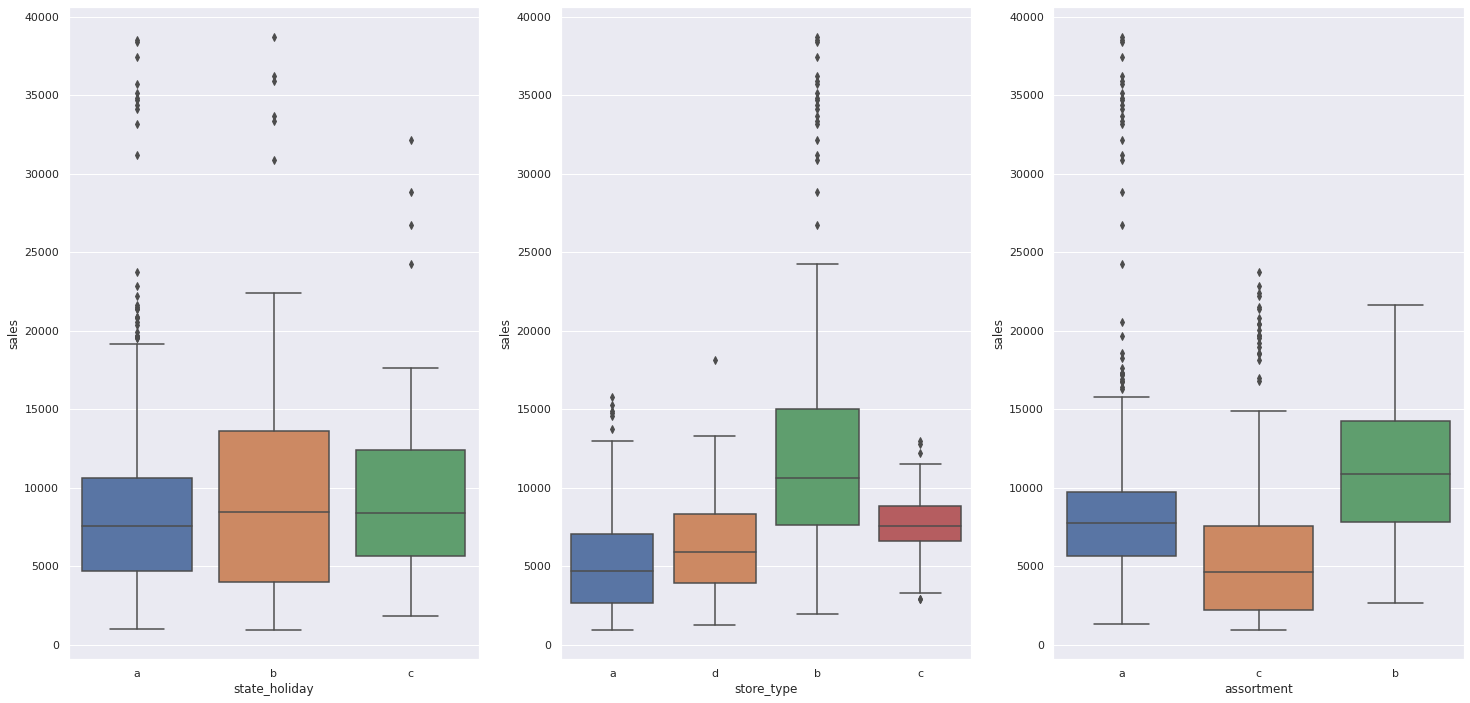

In [15]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## Lista final de hipóteses

1. Lojas com maior sortimentos deveriam vender mais.

 

2. Lojas com competidores mais próximos deveriam vender menos.

 

3. Lojas com competidores à mais tempo deveriam vendem mais.

 

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

 

5. Lojas com mais dias de promoção deveriam vender mais.

 

7. Lojas com mais promoções consecutivas deveriam vender mais.

 

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

 

9. Lojas deveriam vender mais ao longo dos anos.

 

10. Lojas deveriam vender mais no segundo semestre do ano.

 

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

 

12. Lojas deveriam vender menos aos finais de semana.

 

13. Lojas deveriam vender menos durante os feriados escolares.

## Featuring Create

In [17]:
#year
df2['year'] = df2['date'].dt.year


#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] =  ((df2['date'] - df2['competition_since'] ) /30).apply(lambda x: x.days).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] ) / 7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

/tmp/ipykernel_14382/1035908644.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# FEATURE FILTERING

In [18]:
df3 = df2.copy()

## Filtragem das linhas

In [19]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Seleção de Colunas 

In [20]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# EXPLORE DATA ANALYSIS - EDA

In [21]:
df4 = df3.copy()

##  Univariate Analysis

### Response Variable 

/home/alex/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


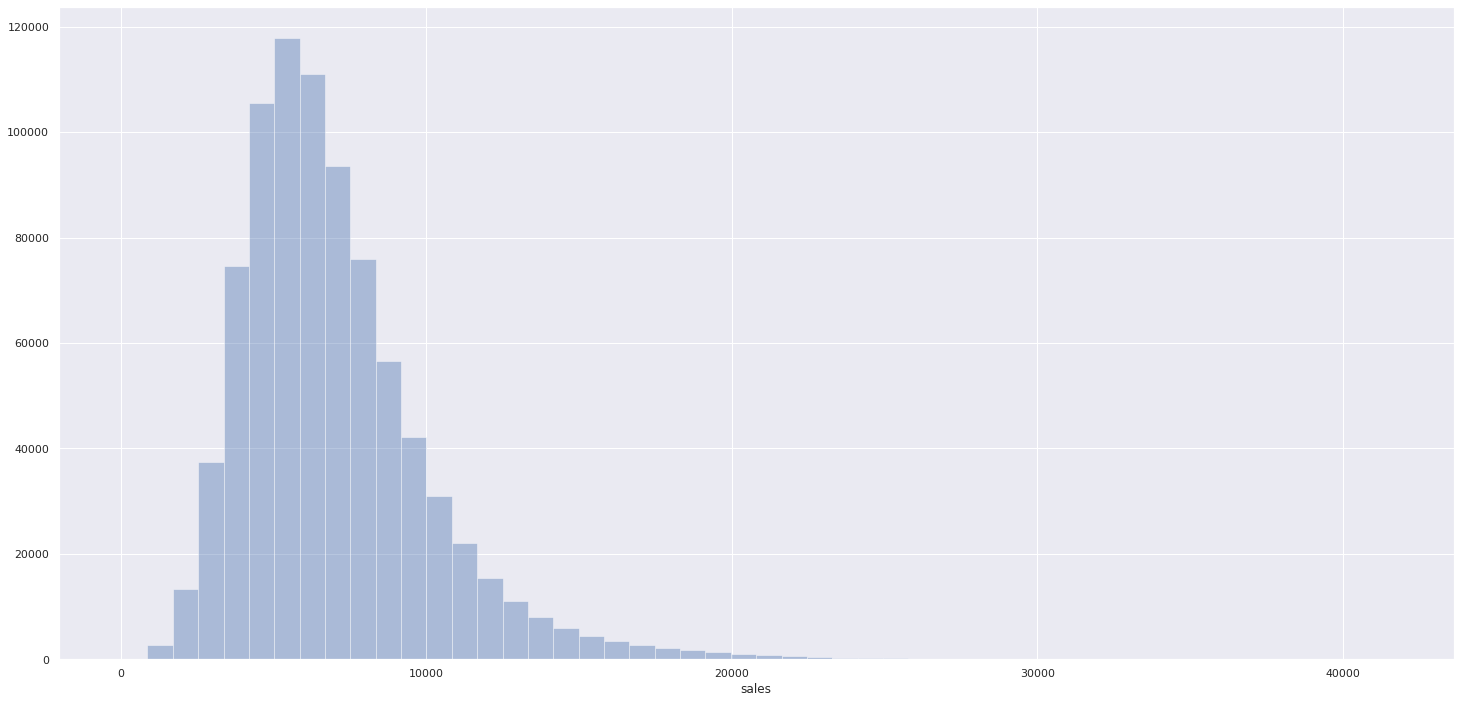

In [22]:
sns.distplot(df4['sales'], kde=False);

### Numerical Variable 

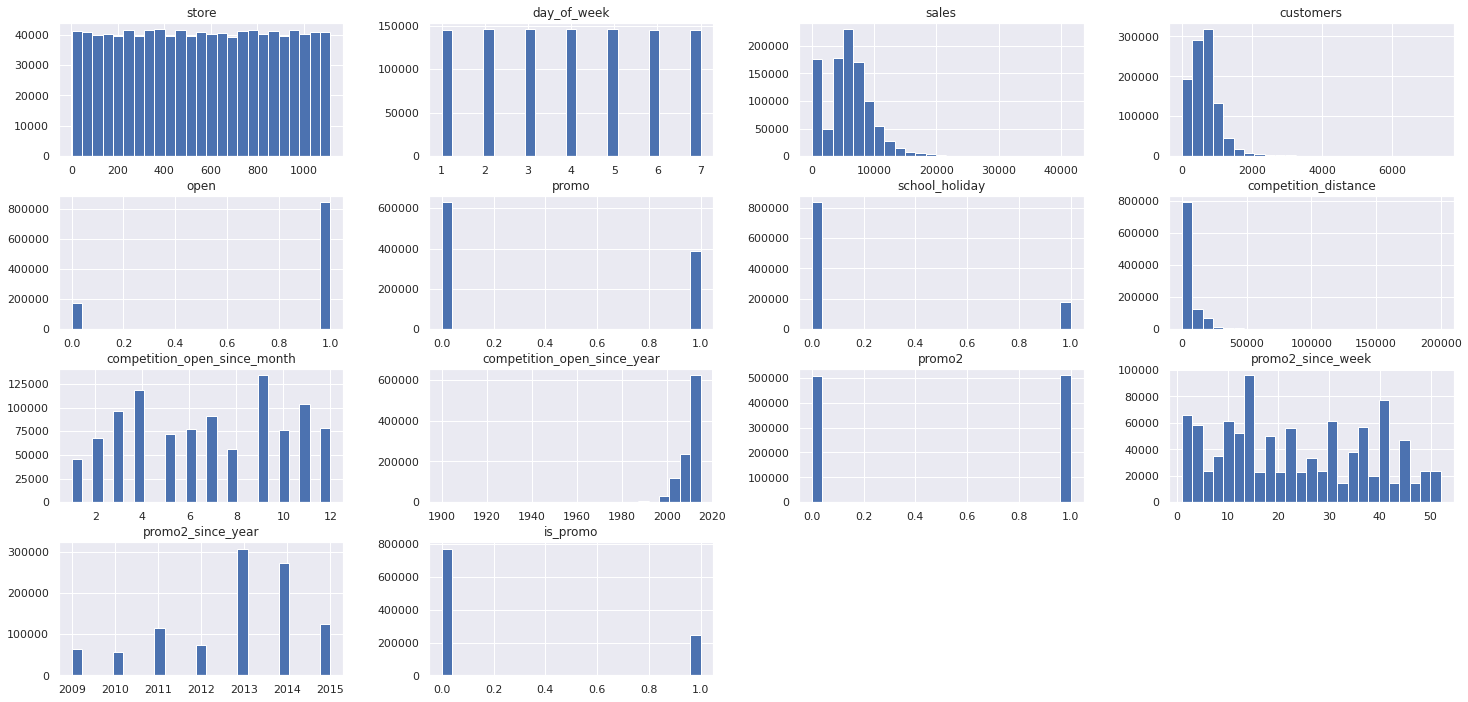

In [23]:
num_attributes.hist(bins=25);

### Categorical Variable 

/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

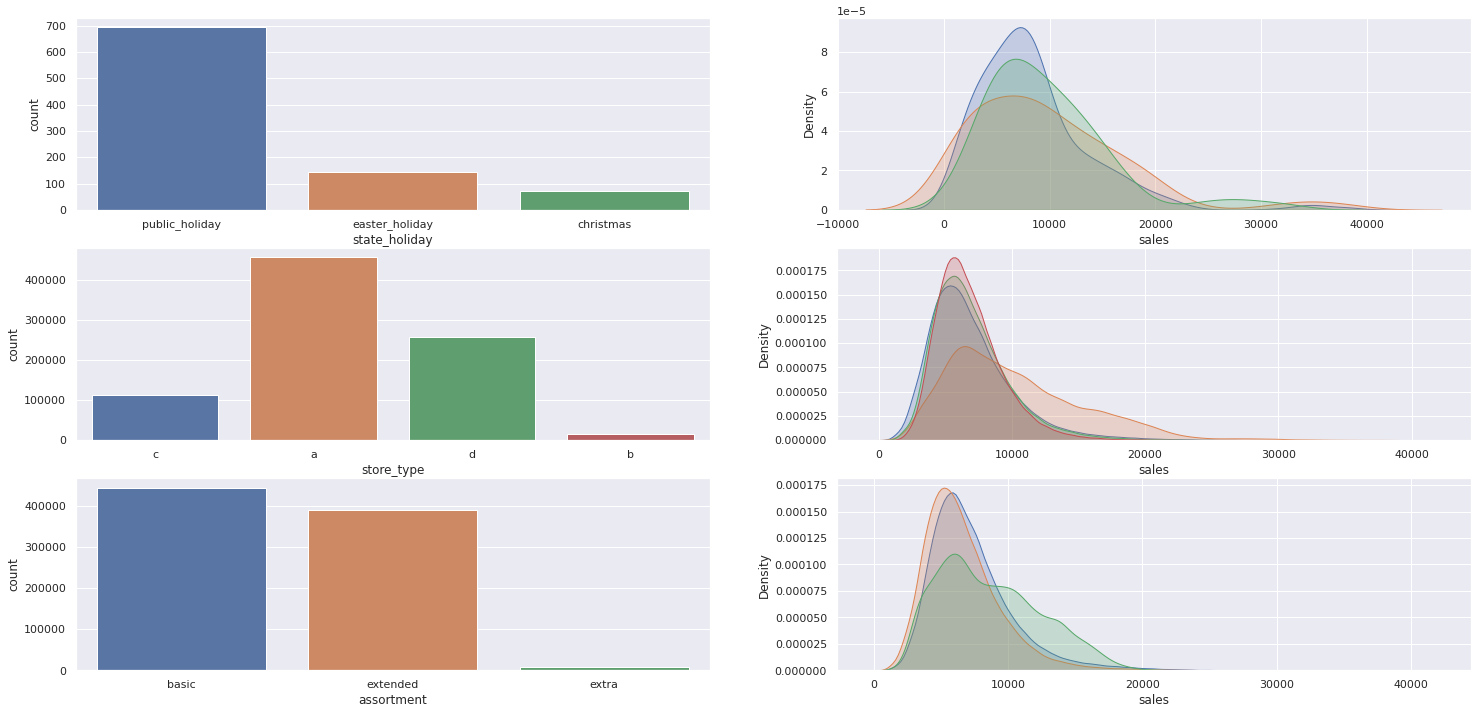

In [24]:
#STATE HOLIDAY
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3, 2, 1)
sns.countplot( a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#STORE TYPE

plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#ASSORTMENT

plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## Bivariete Analysis 

### Lojas com maior sortimentos deveriam vender mais.
**Hipótese Falsa:** lojas com menores sortimentos vendem mais

<AxesSubplot:xlabel='year_week'>

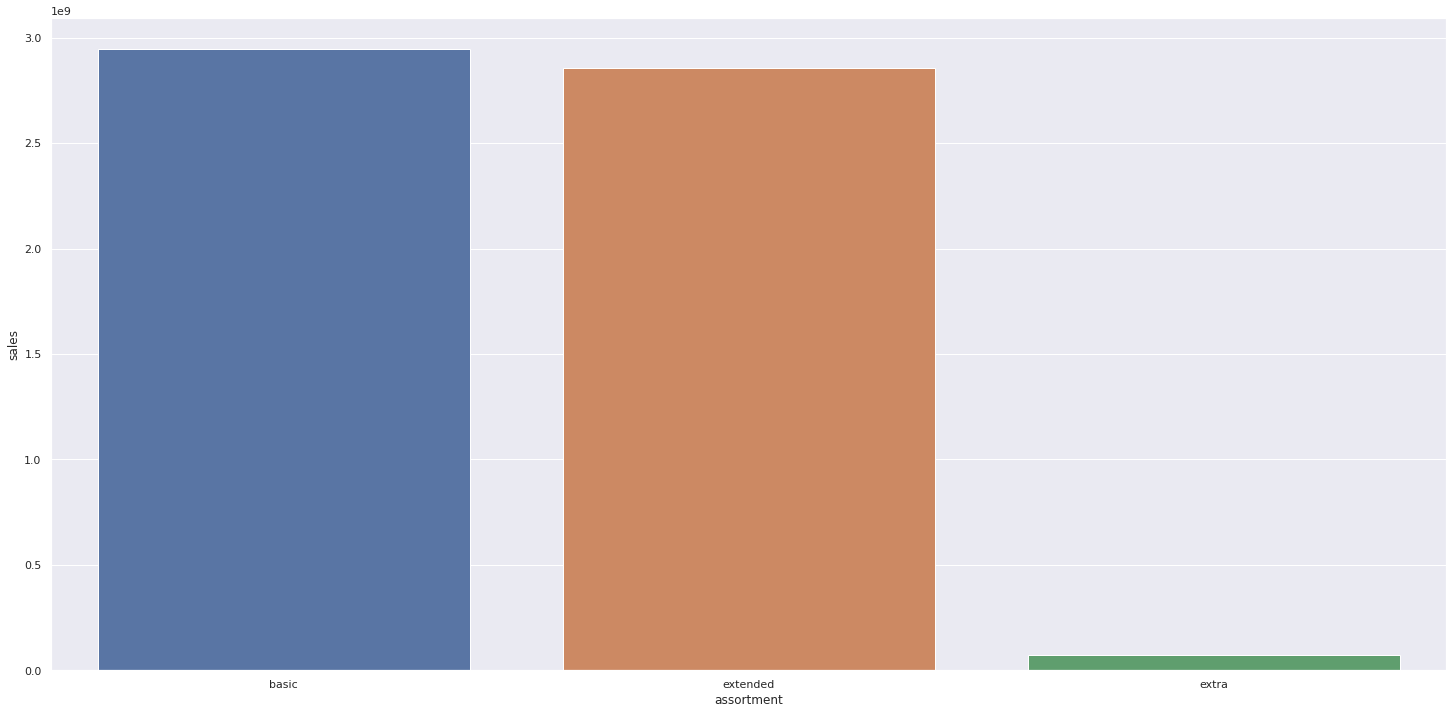

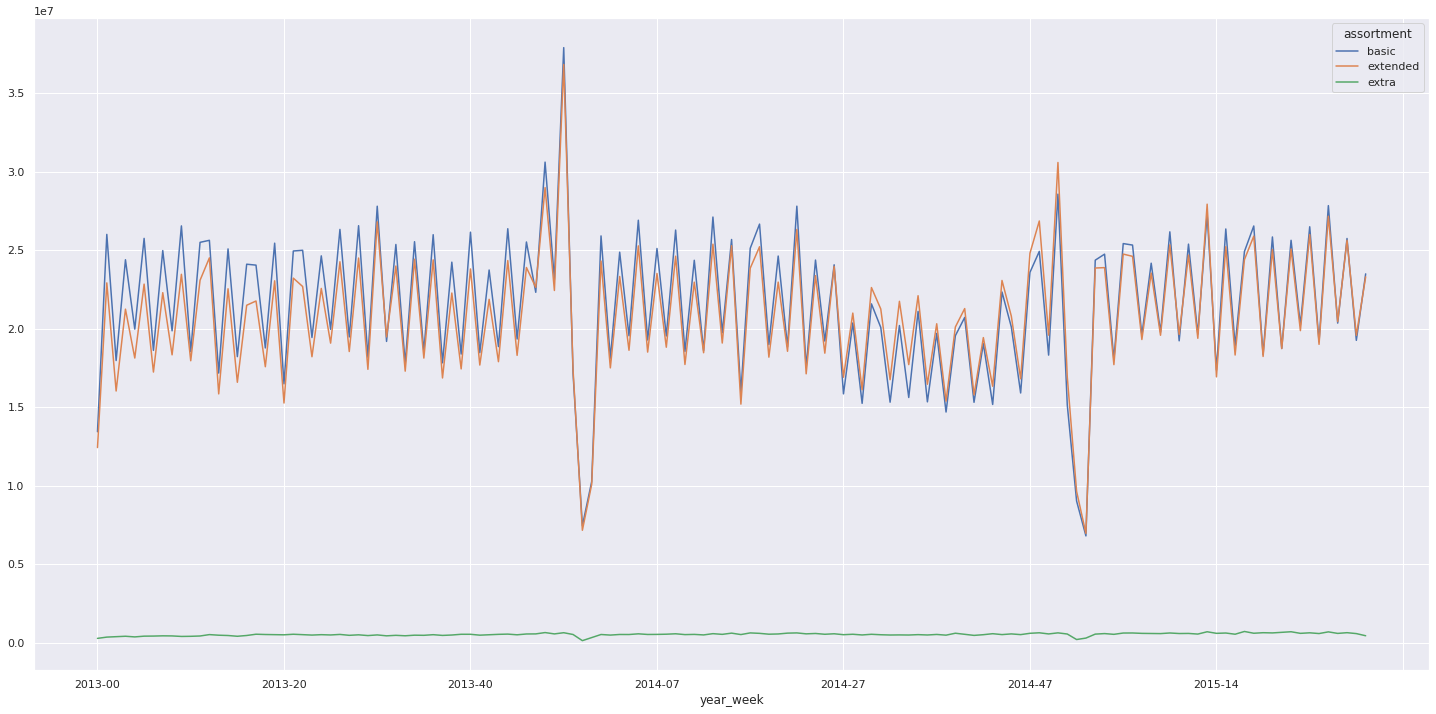

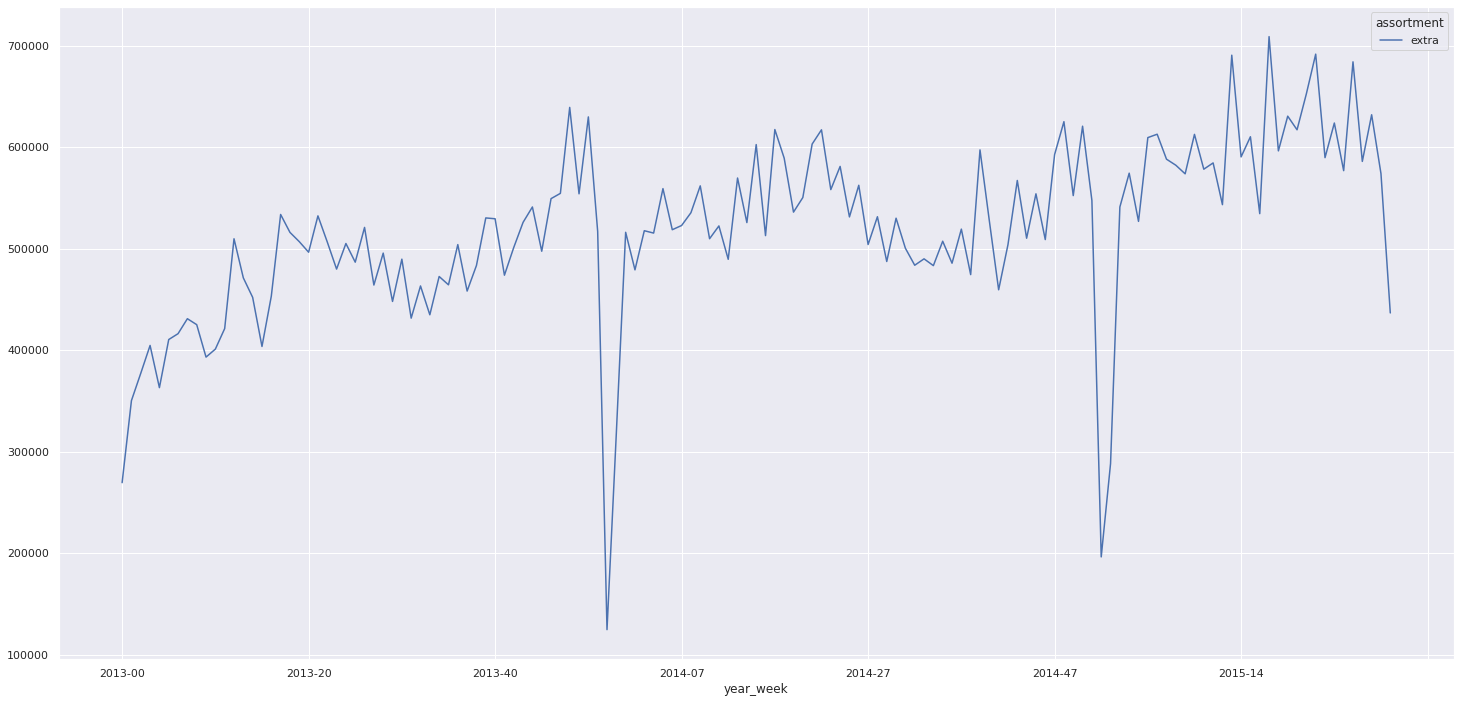

In [25]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week' ,columns='assortment', values='sales')
aux3.plot()

aux4 = aux2[aux2['assortment'] == 'extra']
aux4 = aux4.pivot(index='year_week' ,columns='assortment', values='sales')
aux4.plot()

### Lojas com competidores mais próximos deveriam vender menos.
**Hipótese Falsa:** lojas com competidores mais próximos vendem mais.

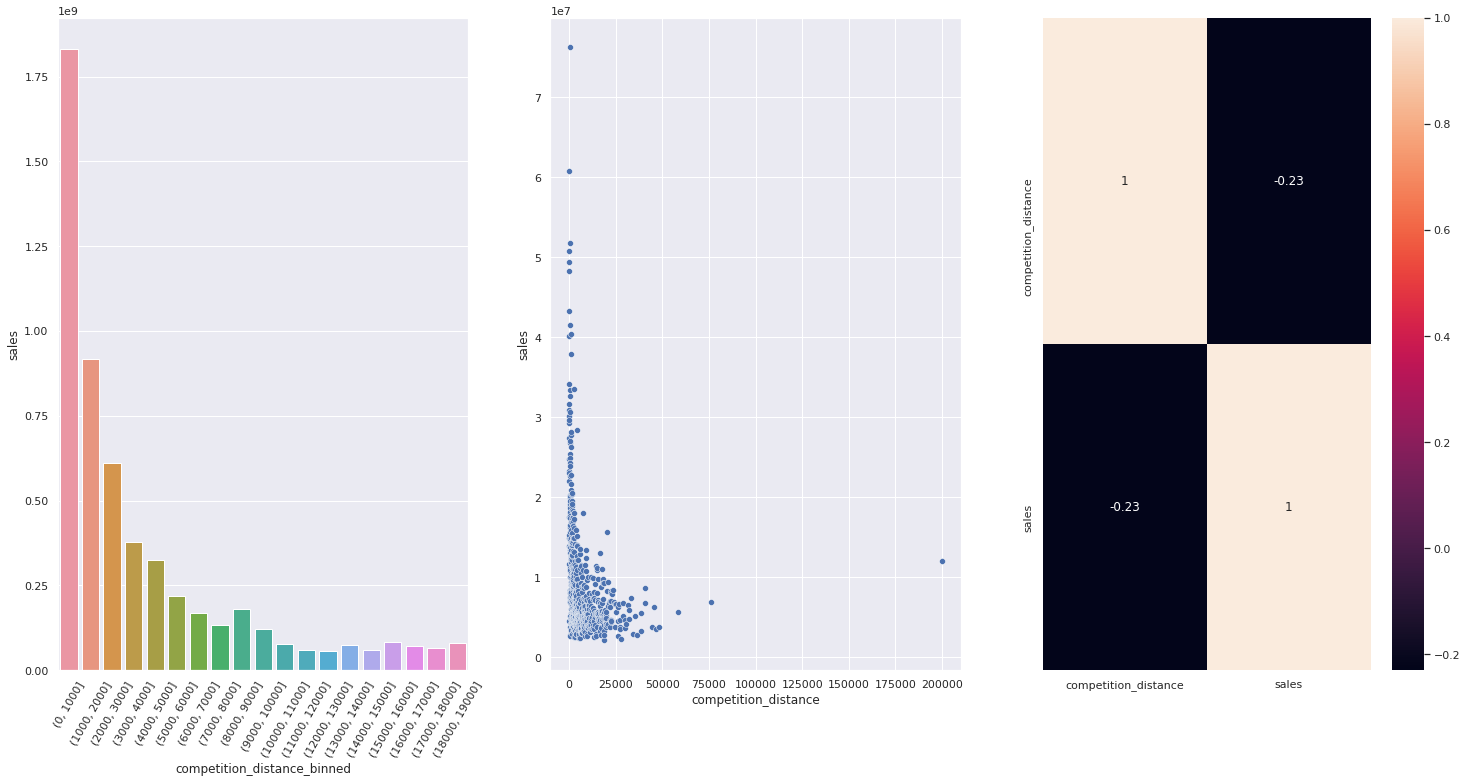

In [26]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)


aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=60);

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1, 3, 2)
sns.scatterplot( x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### Lojas com competidores à mais tempo deveriam vendem mais.
**Hipótese Falsa:** lojas com competidores mais recentes, vendem mais.

<AxesSubplot:>

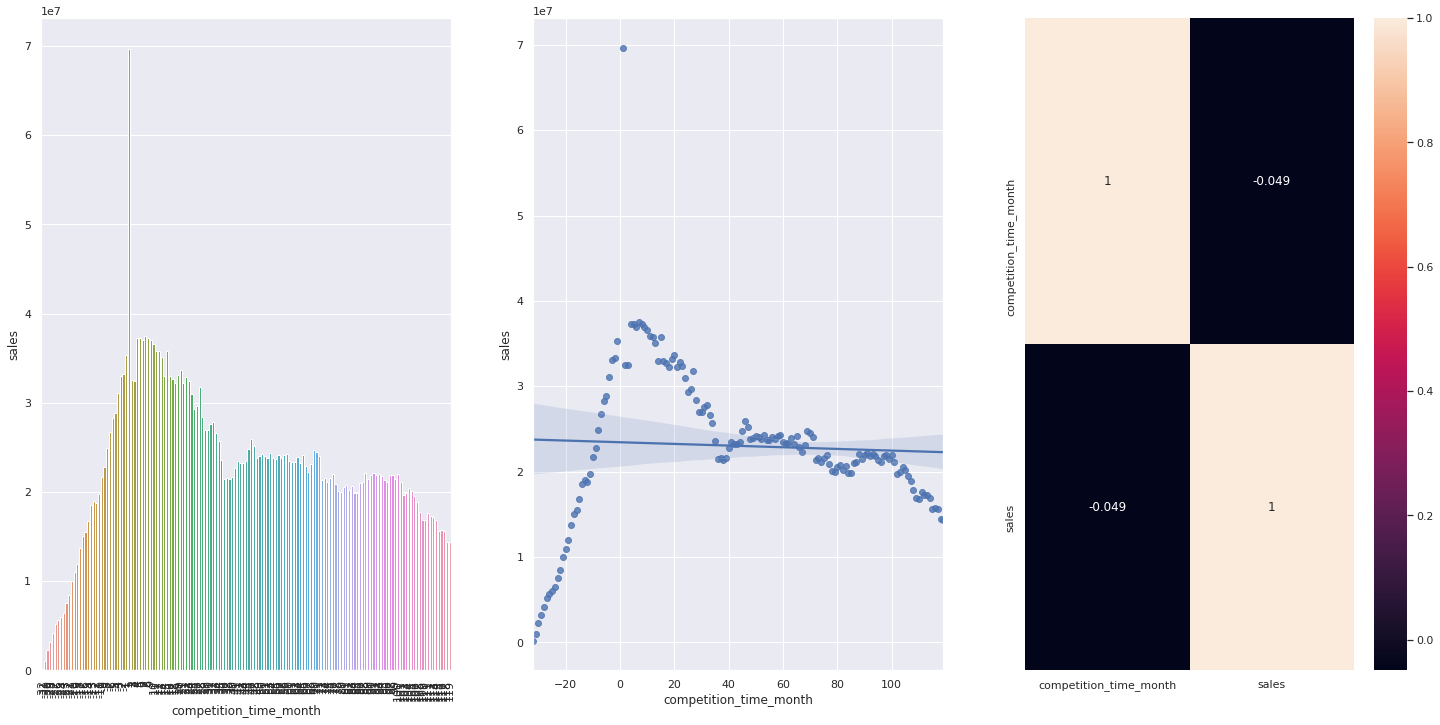

In [27]:
plt.subplot(1, 3, 1)
aux1 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True)

### Lojas com promoções ativas por mais tempo deveriam vender mais.
**Hipótese Falsa:** lojas com promoções ativas a muito tempo vendem menos

<AxesSubplot:>

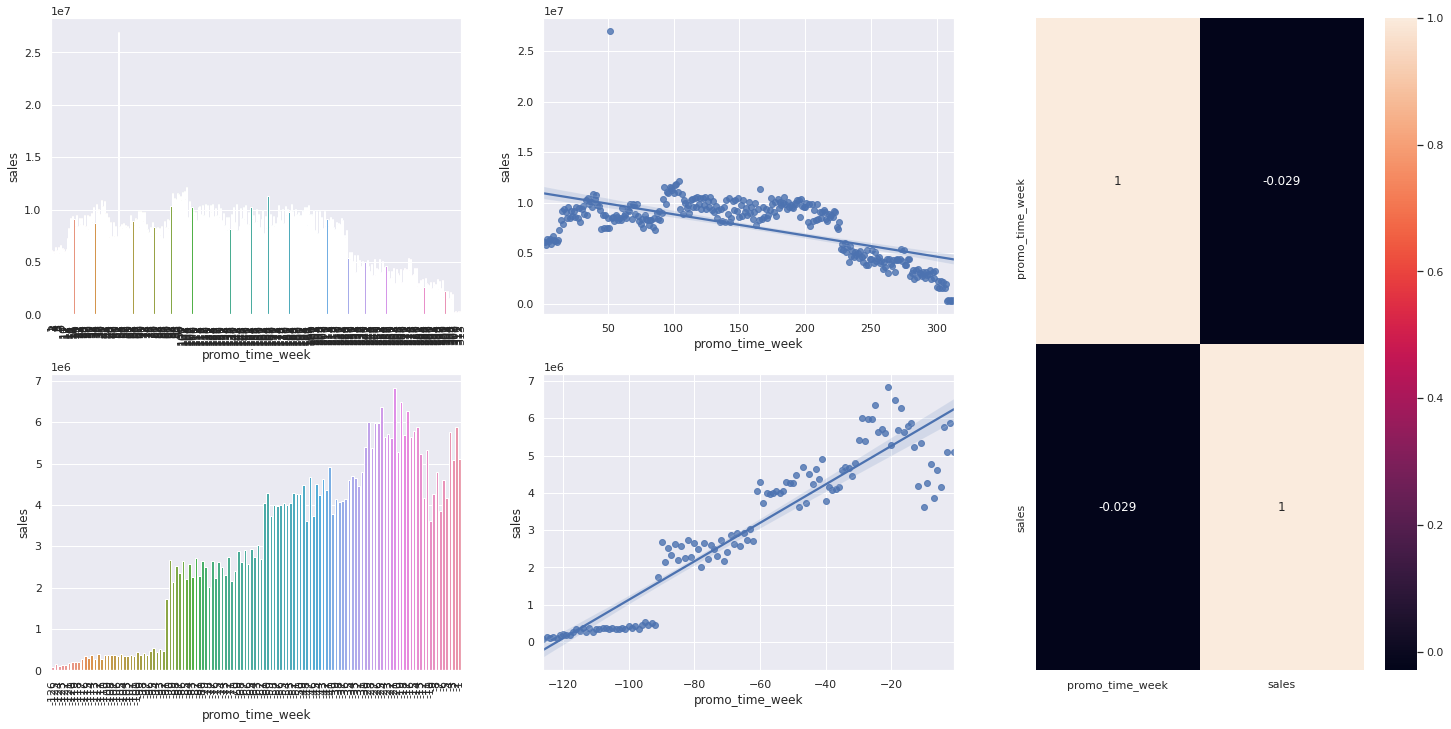

In [28]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

#promo estendido - a promoção esta ativa
aux2 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


#promo regular - a promoção AINDA não está ativa
aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)



### Lojas com mais dias de promoção deveriam vender mais.
**Segundo Ciclo**

### Lojas com mais promoções consecutivas deveriam vender mais.
**Hipótese False:** lojas com mais promoções consecutivas vendem menos

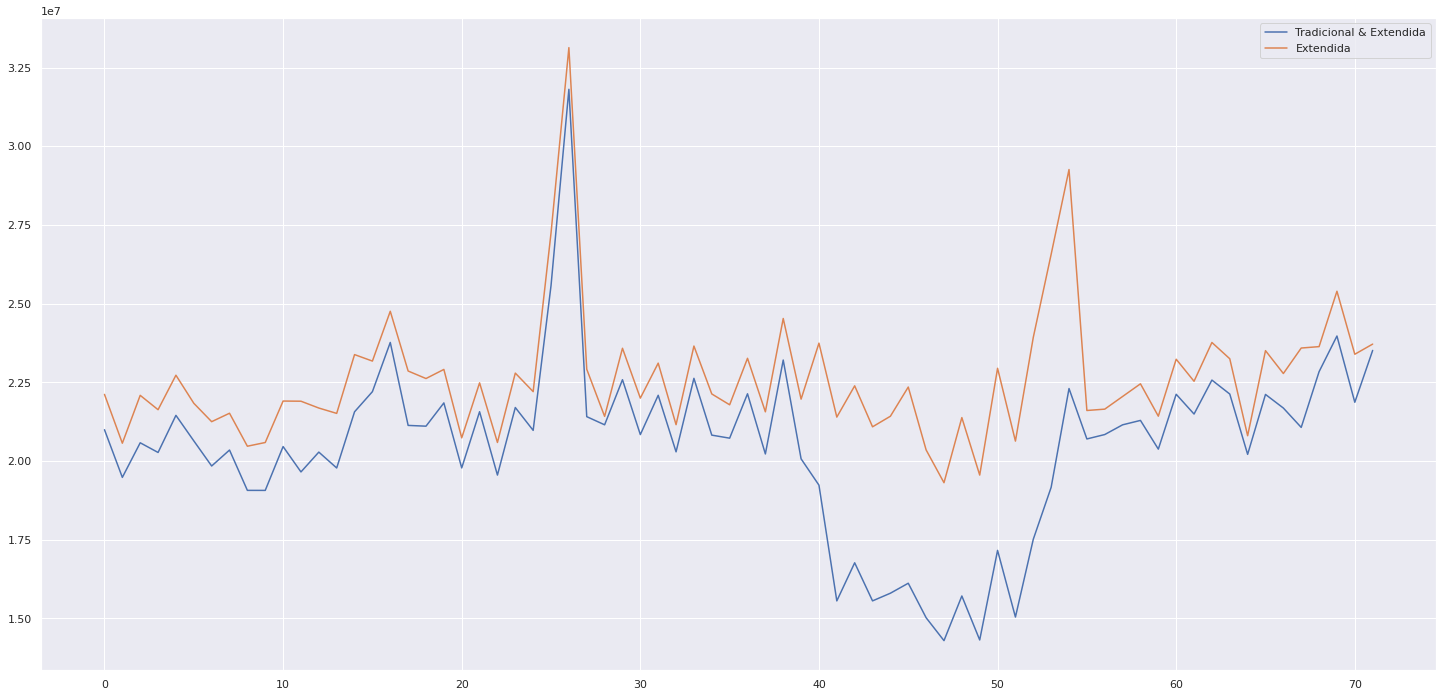

In [29]:
aux1= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2= df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend( labels=['Tradicional & Extendida', 'Extendida'])

### Lojas abertas durante o feriado de Natal deveriam vender mais.
**Hipótese Falsa:** lojas vendem menos durante o feriado do natal

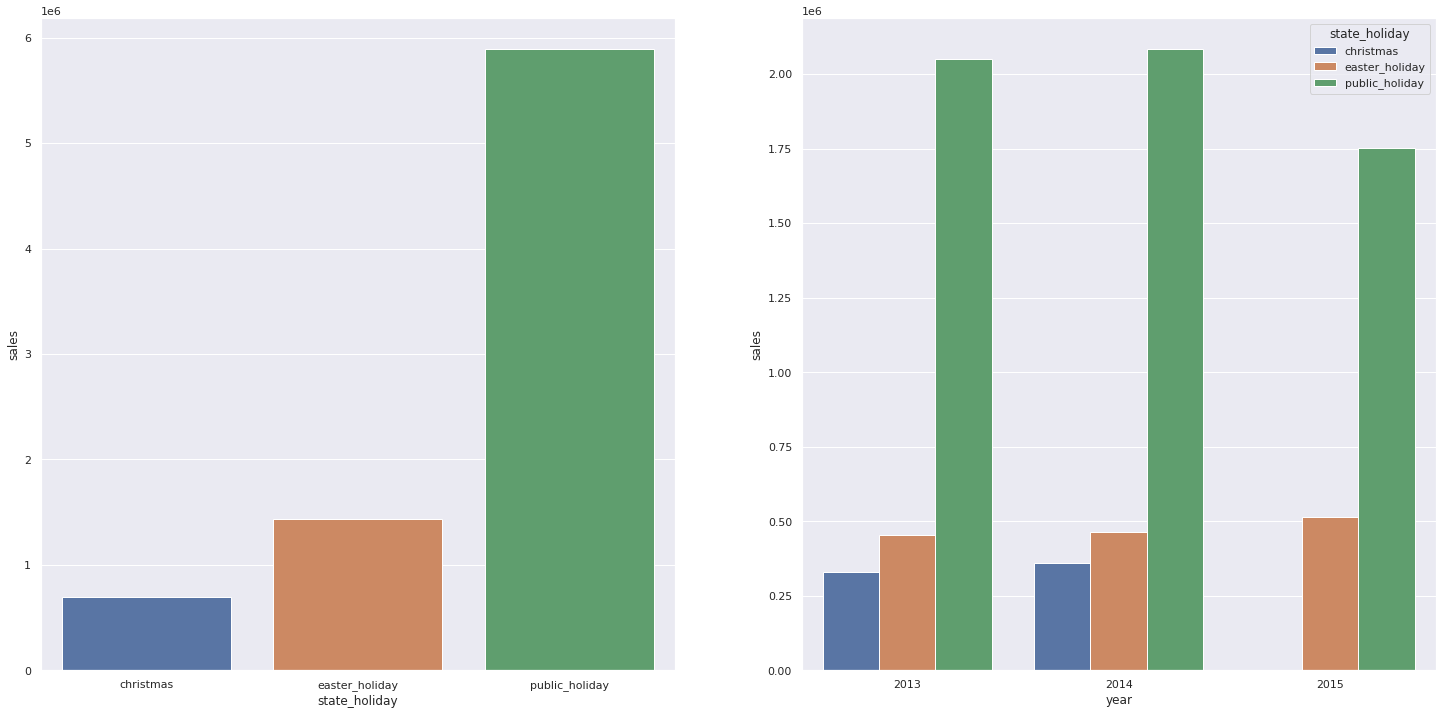

In [30]:
aux1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1);

aux2 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales', 'year']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### Lojas deveriam vender mais ao longo dos anos.
**Hipótese Falsa:** lojas vendem menos ao longo dos anos

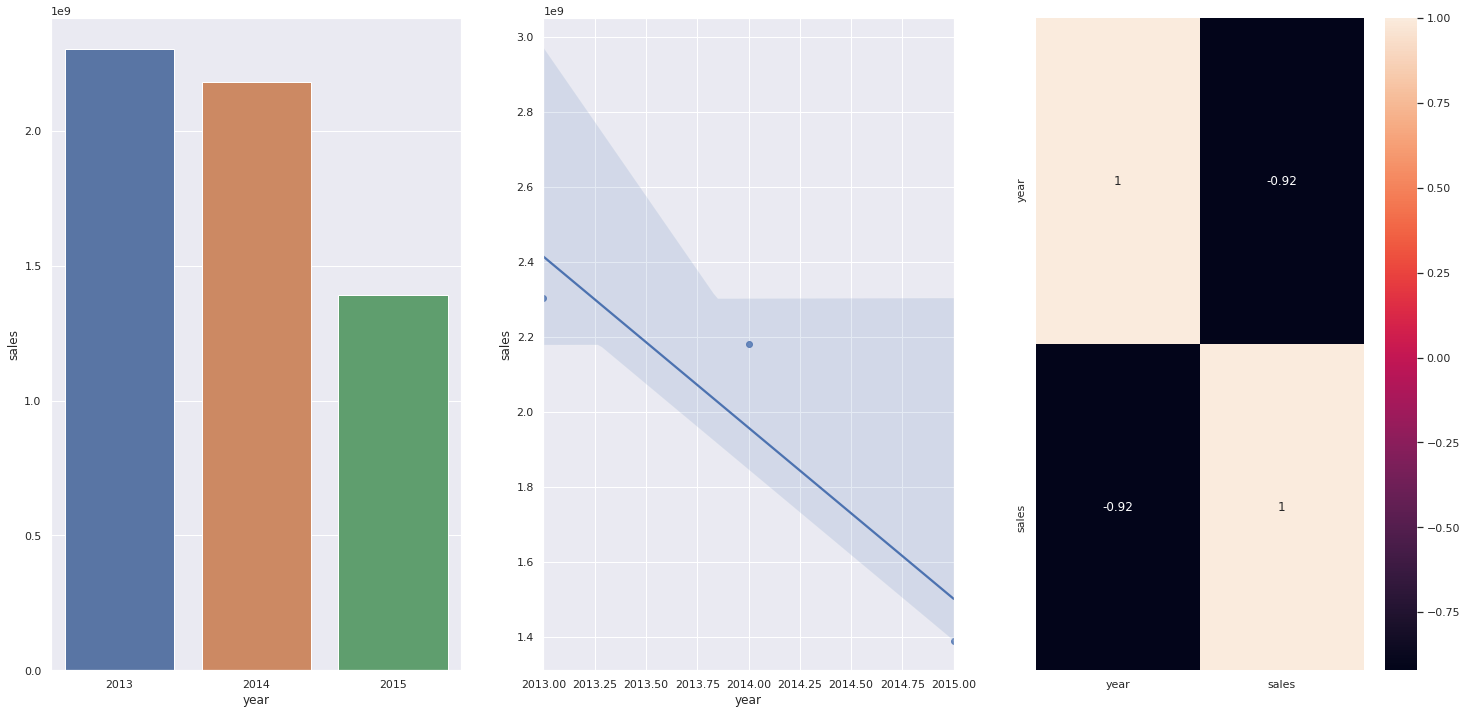

In [31]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### Lojas deveriam vender mais no segundo semestre do ano.
**Hipótese Falsa:** lojas vendem menos no segundo semestre do ano

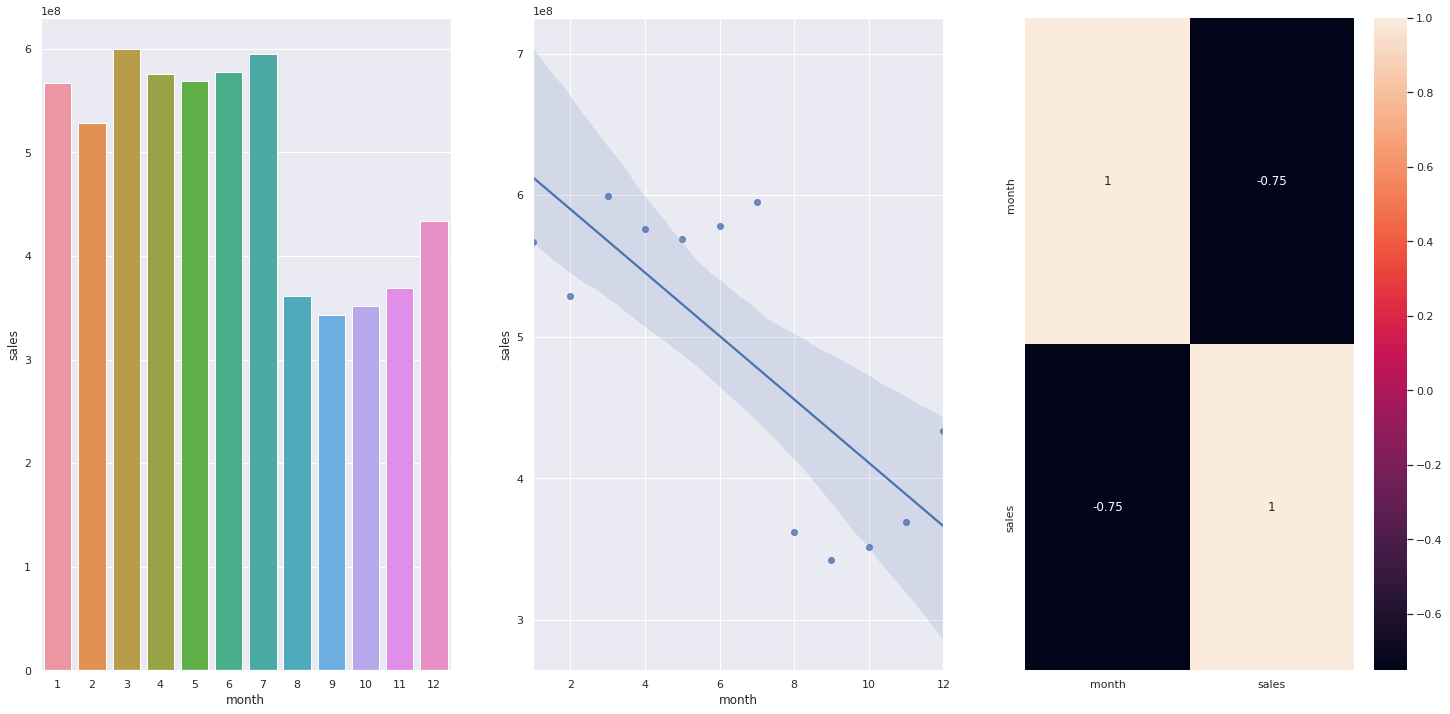

In [32]:
aux1 = df4[['sales', 'month']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### Lojas deveriam vender mais depois do dia 10 de cada mês.
**Hipótese Verdadeira:** lojas vendem mais depois do dia 10

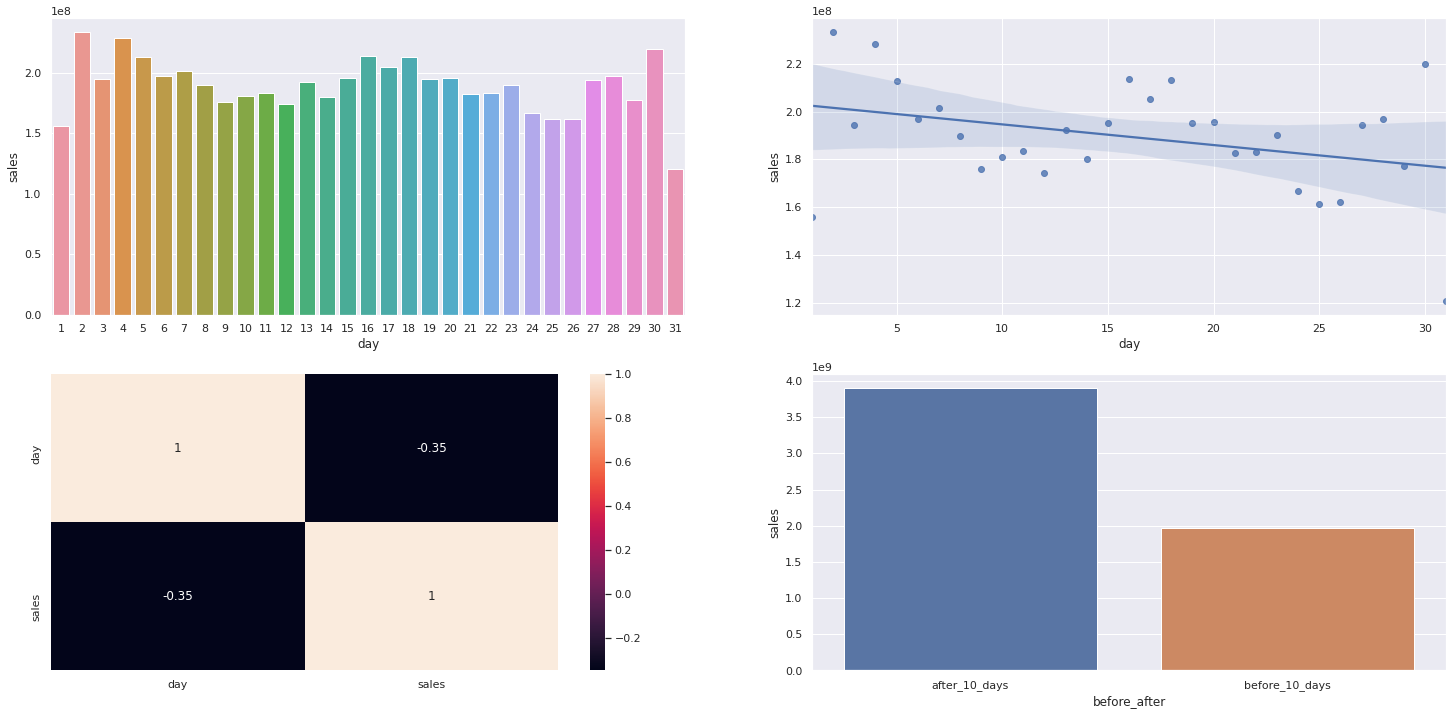

In [33]:
aux1 = df4[['sales', 'day']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['sales', 'before_after']].groupby('before_after').sum().reset_index()
plt.subplot(2, 2, 4)
sns.barplot( x='before_after', y='sales', data=aux2);

### Lojas deveriam vender menos aos finais de semana.
**Hipótese Verdadeira:** lojas vendem menos no final de semana

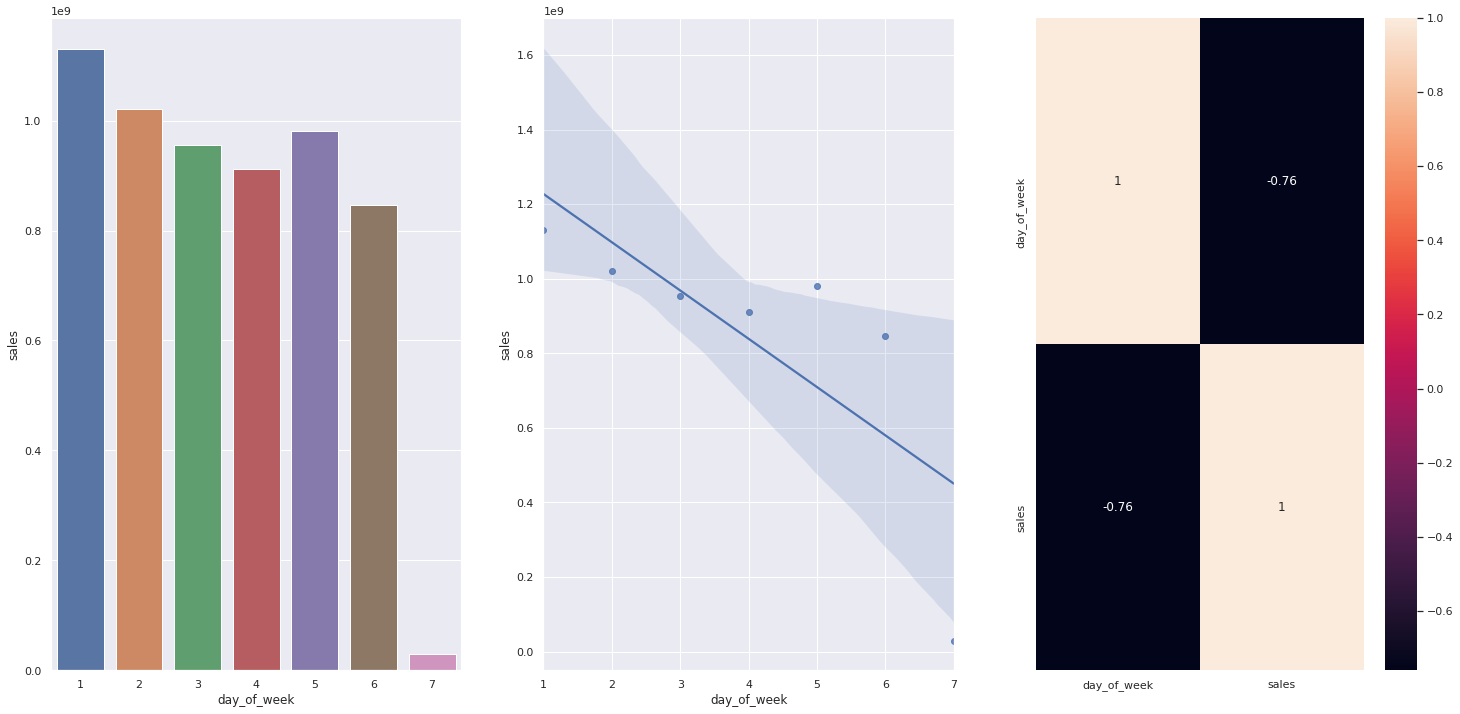

In [34]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### Lojas deveriam vender menos durante os feriados escolares.
**Hipótese Verdadeira:** lojas vendem menos durante feriados escolares, exceto no mes de agosto

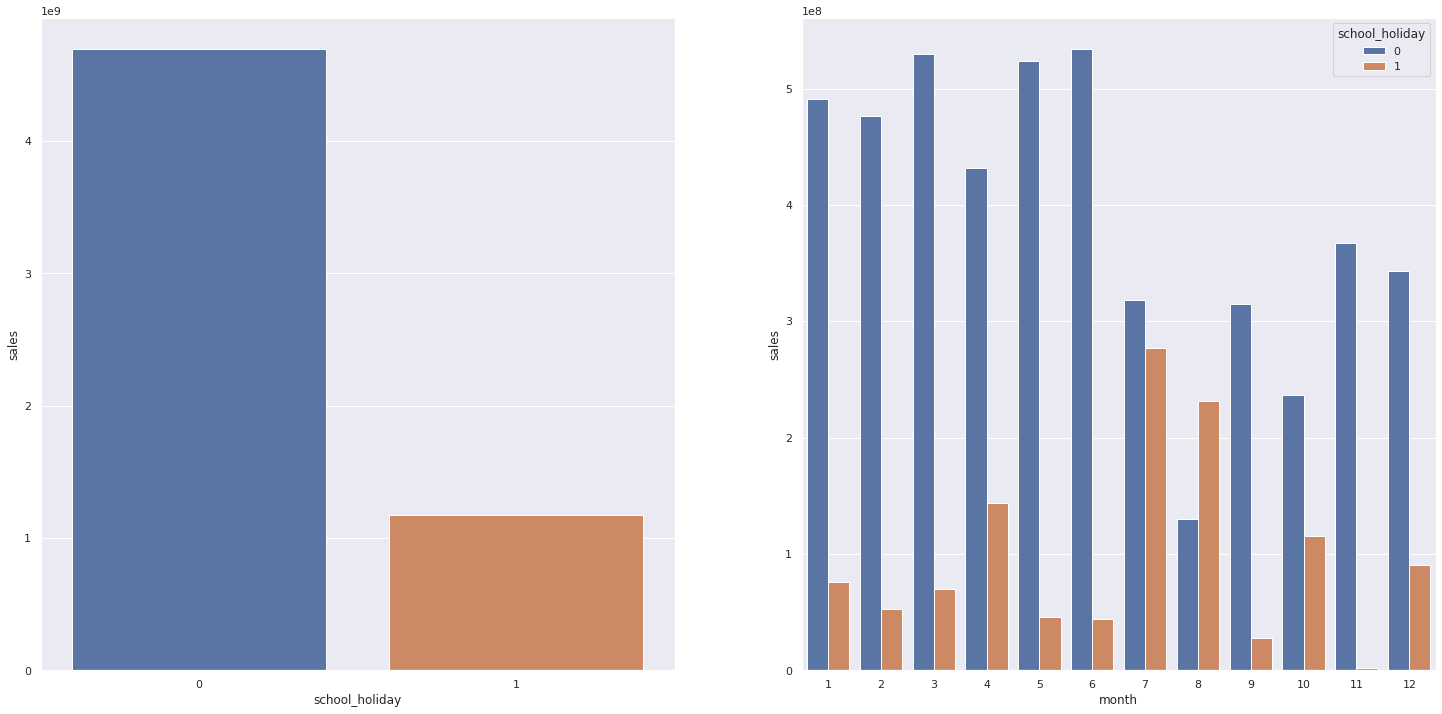

In [35]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);


plt.subplot(1, 2, 2)
aux2 = df4[['month', 'sales', 'school_holiday']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## Multivariate Analysis 

### Numerical Attributes

<AxesSubplot:>

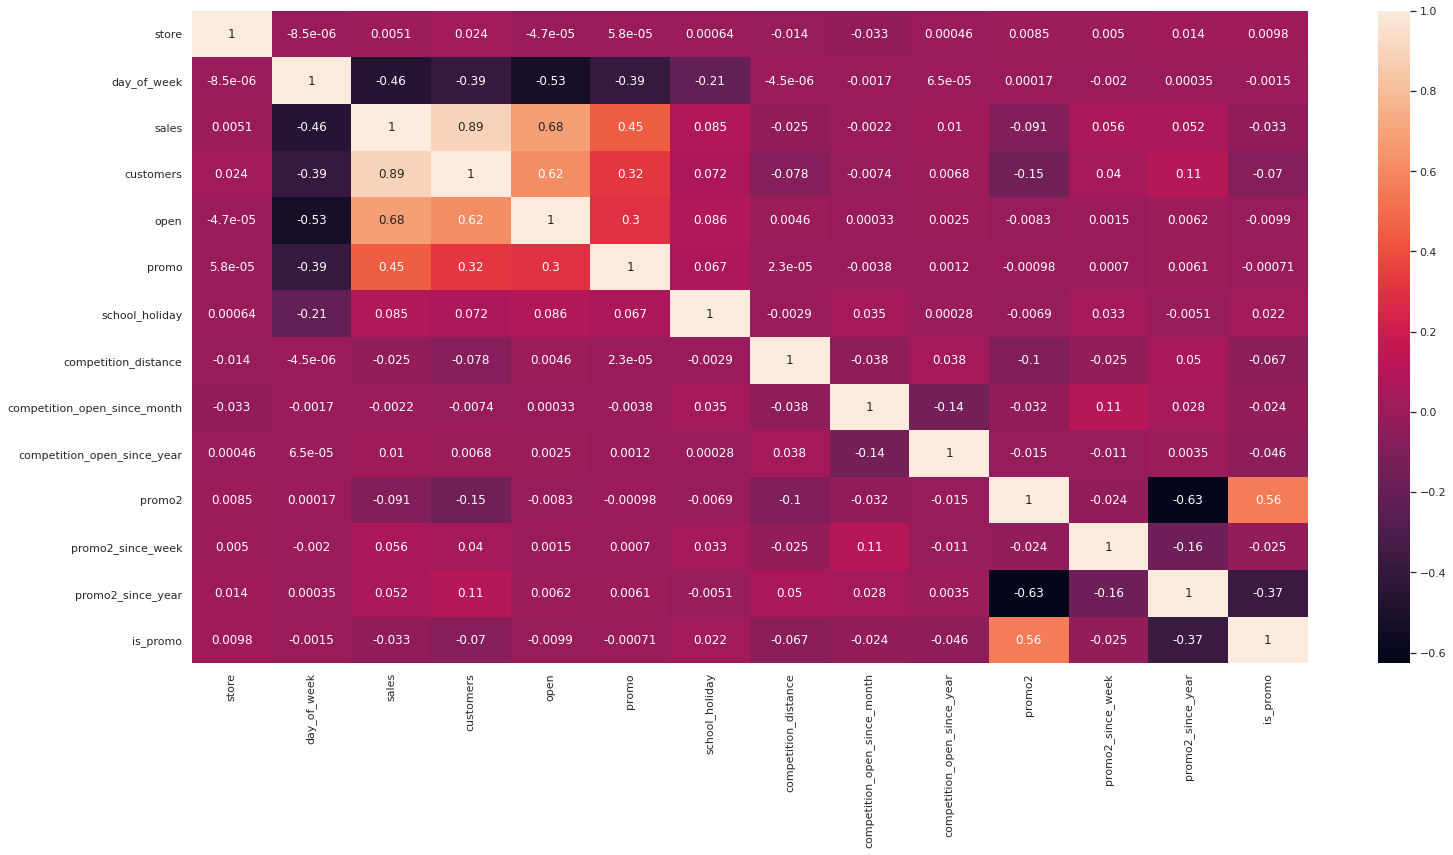

In [36]:
sns.heatmap(num_attributes.corr(method='pearson'),annot=True)

### Categorical Attributes

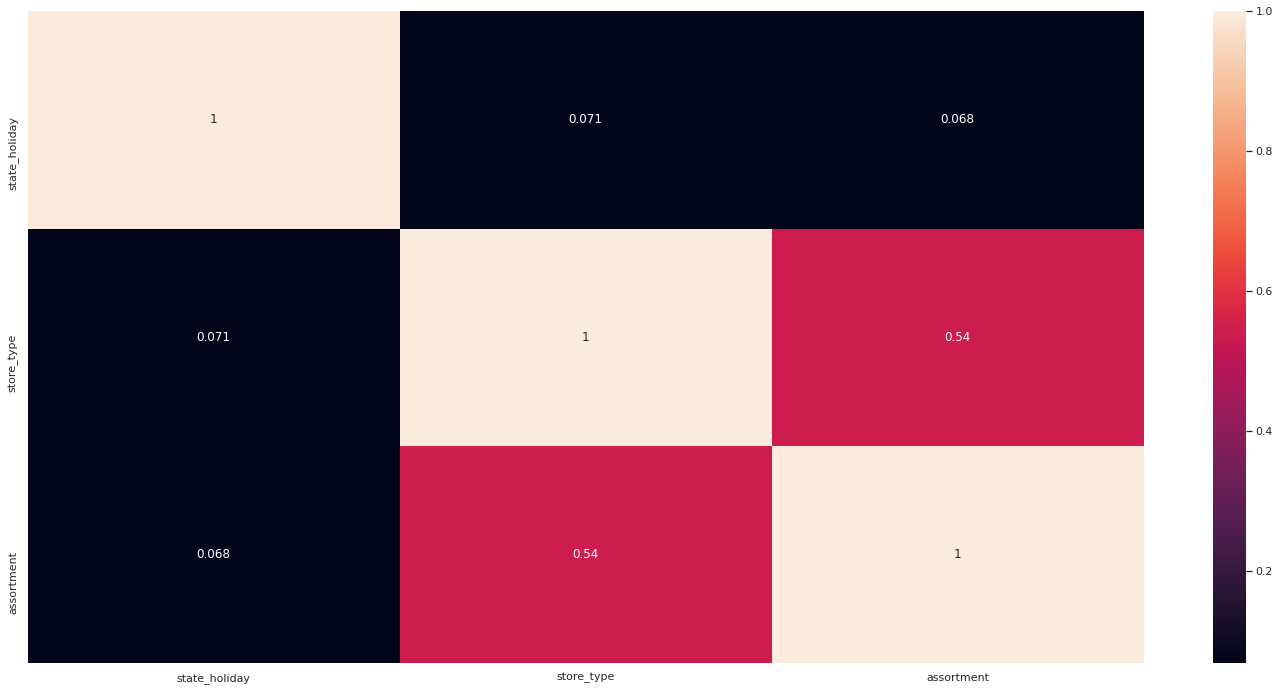

In [37]:
a = df4.select_dtypes( include='object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})

d = d.set_index( d.columns)
sns.heatmap(d, annot=True);

# DATA PREPARATION

In [38]:
df5 = df4.copy()

## Normalização
Não tem nenhuma variável com distribuição normal

## Rescaling
Variáveis que não tem distribuição normal

### Min-Max Scaler
Muito sensível a outliers

In [39]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

df5['year'] = mms.fit_transform( df5[['year']].values)

### Robust Scaler
Mesma formula do min-max, mas ele usa o q3 e q1 em vez do min e max

In [40]:


df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)



## Transformação

### Encoding

In [41]:
#state holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

#store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

#assortment
assortment_dict = { 'basic': 1,
                    'extra': 2,
                    'extended':3}

df5['assortment'] = df5['assortment'].map( assortment_dict )

### Response Variable Transformation

In [42]:
df5['sales'] = np.log1p( df5['sales'] )

### Nature Transformation

In [43]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x* (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x* (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x* (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x* (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x* (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x* (2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x* (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x* (2. * np.pi/52)))

In [44]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.57,1,1,2,1,-0.17,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.92,2015-07-27,0.29,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
1,2,5,2015-07-31,8.71,1,1,0,1,-0.28,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.05,2010-03-22,0.92,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
2,3,5,2015-07-31,9.03,1,1,0,1,1.90,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.20,2011-03-28,0.80,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
3,4,5,2015-07-31,9.55,1,1,2,3,-0.28,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.74,2015-07-27,0.29,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
4,5,5,2015-07-31,8.48,1,1,0,1,4.45,4,2015,0,31,2015,0,1.00,7,31,31,2015-30,2015-04-01,-0.16,2015-07-27,0.29,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82


# FEATURE SELECTION

In [71]:
df6 = df5.copy()

In [72]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

## Split Dataframe into training and test dataset

In [73]:
print('Data mínima: {}'.format(df6[['store', 'date']].groupby('store').min().reset_index()['date'][0])) 
print('Data máxima: {}'.format(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0])) 
#Pegar 6 semanas antes da data máxima, para frente desse valor será a etapa de teste e para tras será a etapa de treino

print('\nA partir dessa data: {} será TESTE e antes será TREINO'.format(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7))) 

Data mínima: 2013-01-02 00:00:00
Data máxima: 2015-07-31 00:00:00

A partir dessa data: 2015-06-19 00:00:00 será TESTE e antes será TREINO


In [74]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## Boruta as Feature Selector

In [75]:
##training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
##define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1)
#
##define boruta
#BorutaPy( rf, n_estimators='auto', verbosa=2, random_state=42 ).fit(X_train_n, y_train_n)
#
#
#cols_selected = boruta.support_.tolist()
#
##best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns
#
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


In [76]:
cols_selected_boruta = ['store', 'promo', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos']

# columns to add

feat_to_add = ['date', 'sales']
#cols_selected_boruta.extend( feat_to_add )
cols_selected_boruta_full = cols_selected_boruta


# MACHINE LEARNING

In [82]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

#Time Series Data preparation
cols_selected_boruta_full.extend( feat_to_add )
x_training = X_train[ cols_selected_boruta_full ]

## Avarage Model

In [83]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, on='store', how='left')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.21,1835.14


## Linear Regression Model 

In [84]:
#model
lr = LinearRegression().fit( x_train, y_train)

#prediction
yhat_lr = lr.predict( x_test )

#performance
lr_result =  ml_error( 'Linear Regressor', np.expm1( y_test ), np.expm1( yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,1867.09,0.29,2671.05


### Linear Regression Model - Cross Validation

In [85]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## Linear Regression Regularized Model - Lasso

In [86]:
#model
lrr = Lasso(alpha=0.01).fit( x_train, y_train)

#prediction
yhat_lrr = lrr.predict( x_test )

#performance
lrr_result =  ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70,0.29,2744.45


### Linear Regression Regularized Model - Cross Validation

In [87]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Regularized', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## Random Forest Regressor

In [88]:
#model
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42).fit( x_train, y_train)

#prediction
yhat_rf = rf.predict( x_test )

#performance
rf_result =  ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,722.70,0.11,1073.97


### Random Forest Regressor Model - Cross Validation

In [89]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,887.55+/-232.49,0.12+/-0.02,1328.39+/-340.35


## XGBoost Regressor

In [90]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10).fit( x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict( x_test )

#performance
xgb_result =  ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.53,0.95,7330.46


### XGBoost Regressor Model - Cross Validation

In [91]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.51+/-587.33,0.95+/-0.0,7713.16+/-688.31


## Compare Model's Performance

In [92]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,722.70,0.11,1073.97
0,Average Model,1354.80,0.21,1835.14
0,Linear Regressor,1867.09,0.29,2671.05
0,Linear Regression - Lasso,1891.70,0.29,2744.45
0,XGBoost Regressor,6683.53,0.95,7330.46


### Compare Cross Validation 

In [93]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,887.55+/-232.49,0.12+/-0.02,1328.39+/-340.35
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Linear Regression Regularized,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,XGBoost Regressor,7047.51+/-587.33,0.95+/-0.0,7713.16+/-688.31


# HYPERPARAMETER FINE TUNNING

## Random Search

In [95]:
import random
import warnings
warnings.filterwarnings( 'ignore' )

In [106]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytee': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [107]:
final_result = pd.DataFrame()
for i in range( MAX_EVAL ):
    #choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                 n_estimators = hp['n_estimators'], 
                                 eta = hp['eta'], 
                                 max_depth = hp['max_depth'],
                                subsample=hp['subsample'],
                                colsample_bytee=hp['colsample_bytee'],
                                min_child_weight=hp['min_child_weight'])

    #performance
    result =  cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
    
    final_result = pd.concat( [final_result, result] )
    
final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 3}
[10:25:10] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:31:48] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 15}
[10:41:58] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1220.41+/-56.94,0.16+/-0.0,1791.97+/-101.71
0,XGBoost Regressor,913.01+/-78.38,0.12+/-0.01,1309.65+/-133.2
0,XGBoost Regressor,835.85+/-84.97,0.11+/-0.01,1212.19+/-147.86
0,XGBoost Regressor,822.55+/-85.28,0.11+/-0.01,1198.82+/-151.76
0,XGBoost Regressor,939.53+/-75.61,0.13+/-0.01,1349.81+/-130.0


## Final Model 

In [108]:
param_tuned = {
'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 8 
        }

In [109]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators = param_tuned['n_estimators'], 
                             eta = param_tuned['eta'], 
                             max_depth = param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytee=param_tuned['colsample_bytee'],
                            min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train )

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

#performance
xgb_result_tuned =  ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned



[17:39:31] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,635.63,0.09,930.06
